# Disclaimer

>Edit: The authors official implementation is now available on GitHub at [github.com/NicoloCavagnero/FreeREA](https://github.com/NiccoloCavagnero/FreeREA). 

This notebook offers a tour of an implementation of [FreeREA: Training-Free Evolution-based Architecture Search](https://arxiv.org/pdf/2207.05135.pdf), by Cavagnero et al, 2022.

This work is not associated in any way or form with the authors and only aims at reproducing the findings presented by the authors in the cited paper. 

The main author has been informed of the publicity of this re-implementation. 

# Search Space: NATS Space
Here, we only focus on the NATS search space. 

# Preliminary: The whole architecture

The actual architecture is represented in the following picture: 

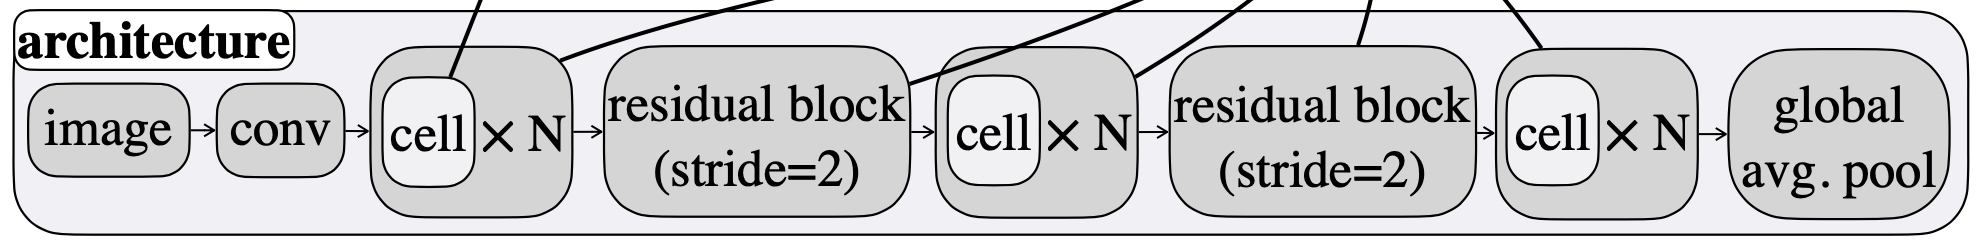

# Preliminary: A Single Cell
An actual single cell is instead presented in the following picture. 



More than that, in the considered picture one can see how the single cell is defined internally. The description in the `|{}|...|{}|` format is what is actually used in the whole algorithm and, in particular, describes the `genotype` associated to a given architecture.

# Data: CIFAR10
At this preliminar stage, this notebook **only tests CIFAR10** as dataset for the given search space. This is done in the sake of an easier debugging phase.

In [2]:
from commons import *

# instantiating a Dataset object
dataset = dataset.Dataset(name="cifar10")
# sampling random images from the dataset object discarding their labels
images = dataset.random_examples()

Files already downloaded and verified
Files already downloaded and verified


# Interface: NATSInterface
Here, we create an instance of a given custom-made interface, `NATSInterface`, which provides useful methods for the task at hand. No full documentation has been yet produced, but the code is sufficiently well-commented. 

In [3]:
# instantiating a NATSInterface object
NATS_PATH = "./archive/NATS-tss-v1_0-3ffb9-simple/"
nats = NATSInterface(path=NATS_PATH, dataset="cifar10")

# sampling a random index
random_idx = np.random.randint(low=0, high=len(nats))
# sampling the architecture (returned as a TinyNetwork object) corresponding to idx random_idx.
random_architecture, random_genotype = nats.query_with_index(idx=random_idx)

# Metrics: naswot
At this stage, we only the metrics described in FreeREA. In particular, the different **training-free** metrics used to score architectures are: 

1. NASWOT: (as described [here](https://arxiv.org/abs/2006.04647)).

2. log-synflow (as described in FreeREA).

3. Portion of skipped layers over all skip connections.

## NASWOT

In [7]:
from metrics.naswot import compute_naswot as naswot
# naswot metric for random architecture
print("NASWOT Score: {:.3e}".format(naswot(net=random_architecture, inputs=images)))

## log-synflow

In [ ]:
from metrics.logsynflow import compute_logsynflow as logsynflow
print("log-Synflow Score: {:.3e}".format(logsynflow(net=random_architecture, inputs=images)))

## Portion of skipped layers
(sidenote: Differently from NASWOT and log-synflow, this metric is genotype-related, therefore its computation needs to be executed considering the genotype only)

In [ ]:
from metrics.skipped_layers import compute_skipped_layers as skipped_layers
print(f"skip connections present in given architecture: {'skip' in ''.join(random_genotype)}")
print("Fraction of skipped layers over total skip connections {:.3e}".format(skipped_layers(random_genotype)))

# Search Strategy - Regularized Genetic Algorithms
Here we reproduce the authors' findings with respect to the algorithms used. 

In [ ]:
def score_naswot(individual:Individual): 
    """Scores each individual with respect to the naswot score"""
    individual.naswot_score = naswot(individual.net, inputs=images)
    return individual

def score_logsynflow(individual:Individual): 
    """Scores each individual with respect to the log-synflow score"""
    individual.logsynflow_score = logsynflow(individual.net, inputs=images)
    return individual

def score_skipped(individual:Individual): 
    """Scores each individual with the fraction of skipped layers over the possible skip connections"""
    individual.skip_score = skipped_layers(individual.genotype)
    return individual

In [ ]:
from commons.genetics import Population
import time
# initialize a random population
population = Population(space=nats, init_population=True, n_individuals=10)

# NASWOT scored population
start_time = time.time()
population.apply_on_individuals(function=score_naswot)
naswot_time = time.time() - start_time
print("NASWOT scoring time: {:.3e} (s)".format(naswot_time))

# LOGSYNFLOW scored population
start_time = time.time()
population.apply_on_individuals(function=score_logsynflow)
logsynflow_time = time.time() - start_time
print("LOG-Synflow scoring time: {:.3e} (s)".format(logsynflow_time))

# NASWOT scored population
start_time = time.time()
population.apply_on_individuals(function=score_skipped)
skip_time = time.time() - start_time
print("PortionOfSkips scoring time: {:.3e} (s)".format(skip_time))

Consistently to what has been by the authors, we then normalize the score of each individual in the [0,1] range considering the *maximal* and *minimal* value of the given metric in the actual population considered.

In [ ]:
for score in ["naswot_score", "logsynflow_score", "skip_score"]: 
    population.normalize_scores(score=score, inplace=True)  # normalize values to bring metrics in the same range

## Fitness function: 
The authors use as fitness function a combination (sum) of the three scores.

In [ ]:
def fitness_score(individual:Individual)->float: 
    """Sums the three scores to obtain final expression for fitness"""
    scores = ["naswot_score", "logsynflow_score", "skip_score"]
    return sum([getattr(individual, score) for score in scores])

population.update_fitness(fitness_score)

## Regularized Evolutionary Algorithm

In [ ]:
from freeREA import *
solution = FreeREA()

result = solution.search()

In [ ]:
from nats_bench import create
from pprint import pprint

original_api = create(NATS_PATH, search_space="topology", fast_mode=True, verbose=False)
result_arch = utils.genotype_to_architecture(result.genotype)
pprint(original_api.query_info_str_by_arch(result_arch))